# <font color="red">**Assignment 5 Previsione_Affidabilità_Creditizia**</font>
Sei stato assunto dalla Pro National Bank come data scientist, e il tuo primo incarico consiste nel realizzare un modello in grado di stimare l'affidabilità creditizia dei clienti, al fine di aiutare il team dedicato a comprendere se accettare o meno la richiesta per il rilascio della carta di credito.

# <font color="red">**Obiettivo del Progetto**</font>
Devi realizzare un modello che preveda il target dato, ovvero la variabile TARGET che indica se il cliente ha una buona affidabilità creditizia.

In [ ]:
# Import delle librerie necessarie
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import shap
import matplotlib.pyplot as plt

### <font color="yellow">***Esplorazione del Dataset***</font>

In [ ]:
# Caricamento del file csv e visualizzazione
url = "https://proai-datasets.s3.eu-west-3.amazonaws.com/credit_scoring.csv"
df = pd.read_csv(url)

# per evitare che il print vada a capo
pd.set_option('display.expand_frame_repr', False)

print(df.head(10))

# Statistiche
print("\nStatistiche descrittive:")
print(df.describe())

        ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  TARGET
0  5008804           M            Y               Y             0         424380.57               Working               Higher education        Civil marriage   Rented apartment    -11778.0        -4438.0         1.0              1.0         0.0         0.0             NaN              2.0       0
1  5008805           M            Y               Y             0         421593.52               Working               Higher education        Civil marriage   Rented apartment    -11777.0        -4459.0         1.0              1.0         0.0         0.0             NaN              2.0       0
2  5008806           M            Y               Y             0         110958.51               Worki

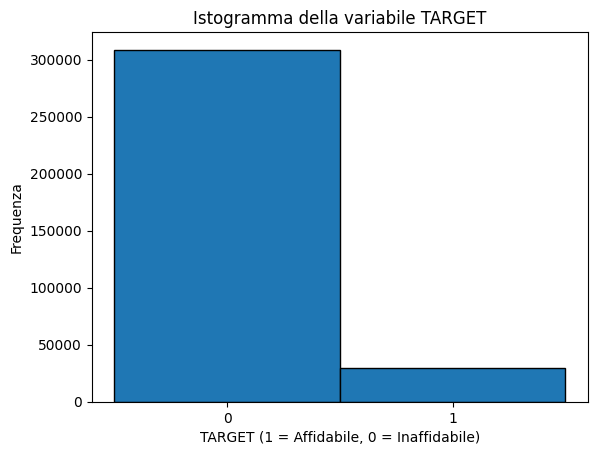

In [ ]:
# Creazione dell'istogramma per la variabile TARGET
plt.figure()
plt.hist(df['TARGET'], bins=[-0.5, 0.5, 1.5], edgecolor='black')
plt.xticks([0, 1])
plt.xlabel('TARGET (1 = Affidabile, 0 = Inaffidabile)')
plt.ylabel('Frequenza')
plt.title('Istogramma della variabile TARGET')
plt.show()

Chiaramente c'è uno sblinciamento nella classi target del dataset, andrà tenuto in considerazione questo fattore durante l'addestramento del modello

Ora procedo con una analisi visiva delle distribuzioni delle variabili nel dataset

<Figure size 600x400 with 0 Axes>

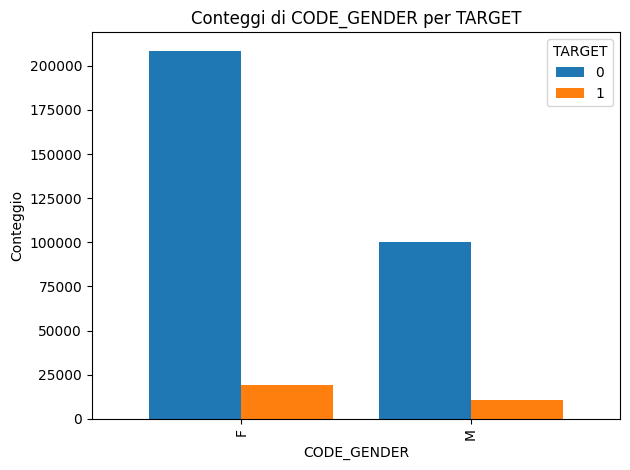

<Figure size 600x400 with 0 Axes>

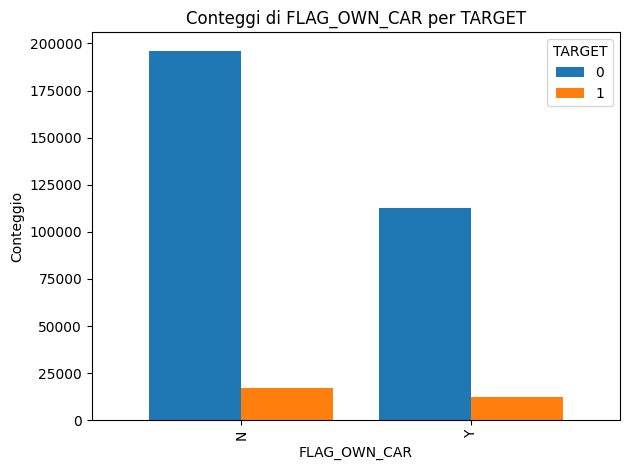

<Figure size 600x400 with 0 Axes>

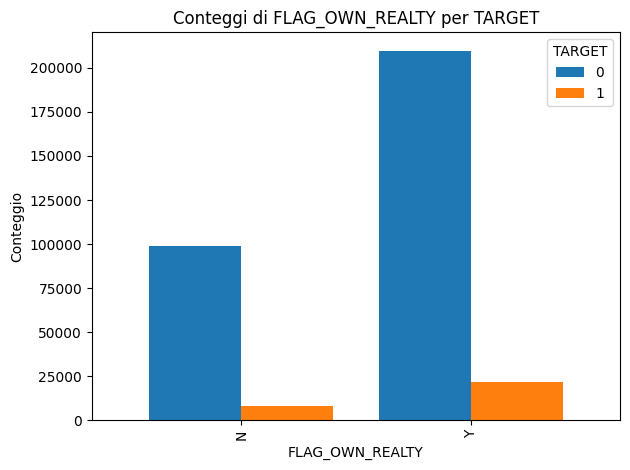

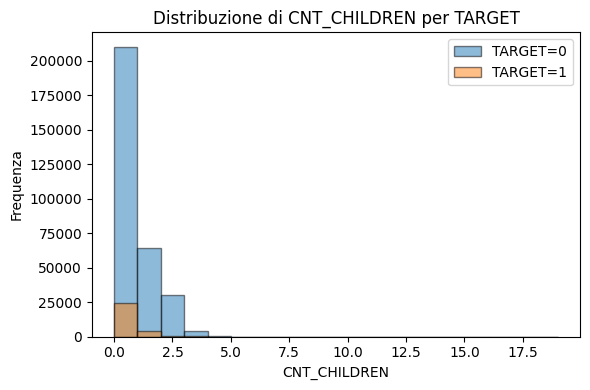

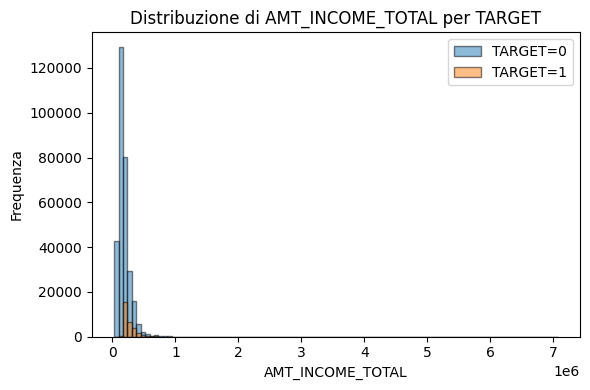

<Figure size 600x400 with 0 Axes>

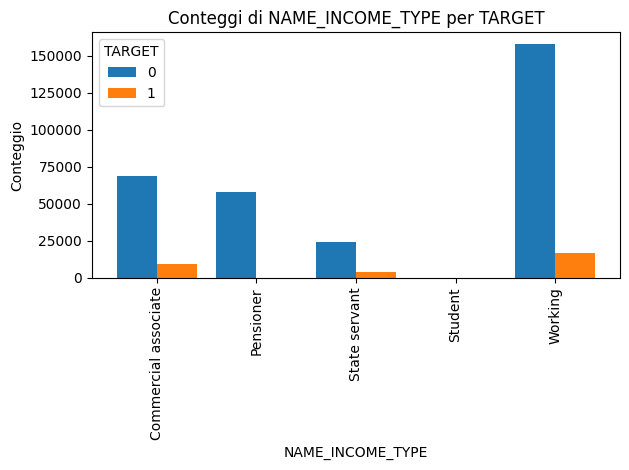

<Figure size 600x400 with 0 Axes>

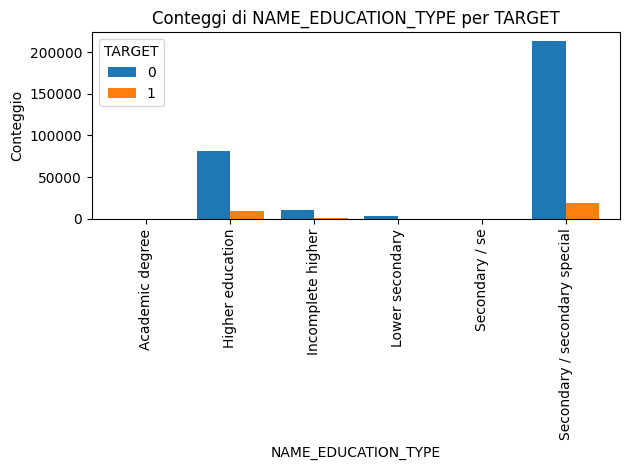

<Figure size 600x400 with 0 Axes>

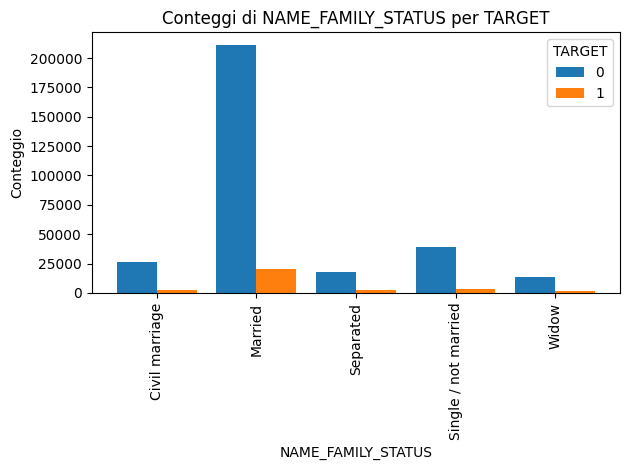

<Figure size 600x400 with 0 Axes>

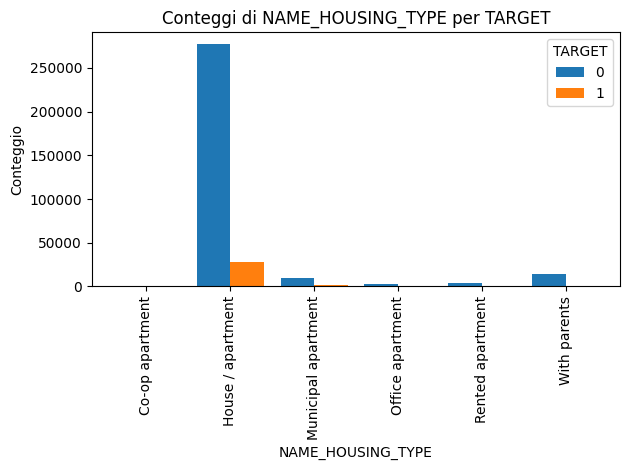

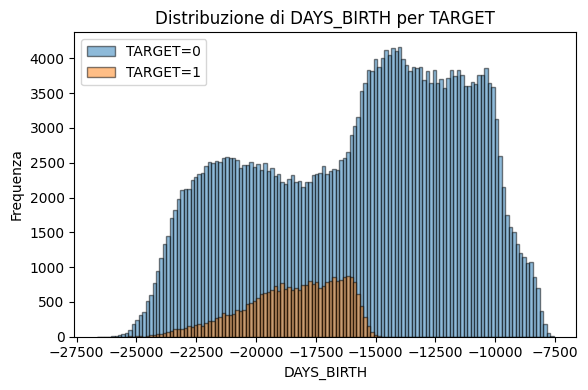

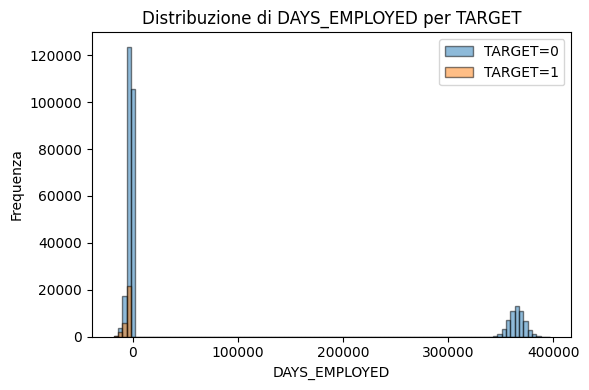

<Figure size 600x400 with 0 Axes>

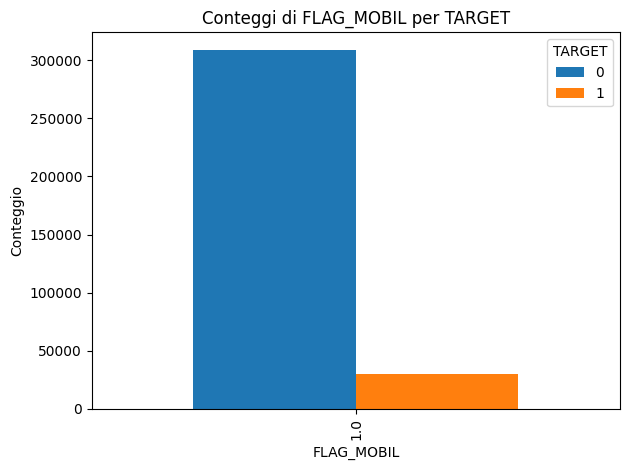

<Figure size 600x400 with 0 Axes>

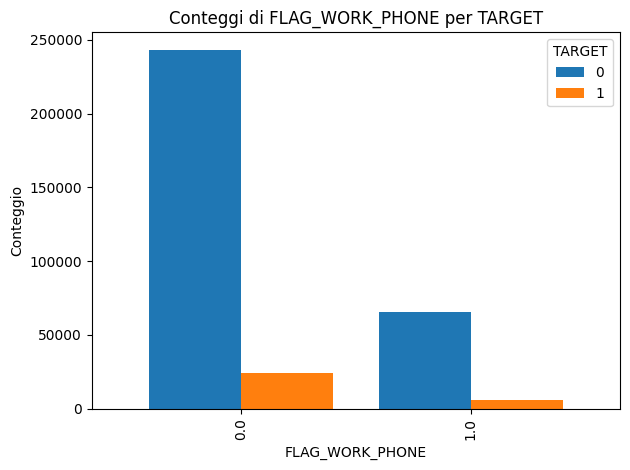

<Figure size 600x400 with 0 Axes>

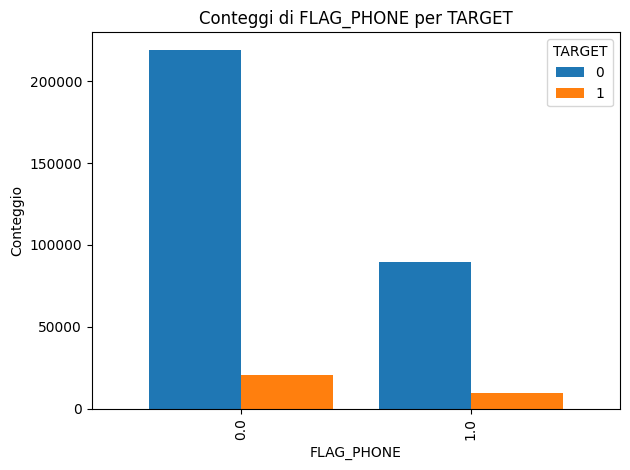

<Figure size 600x400 with 0 Axes>

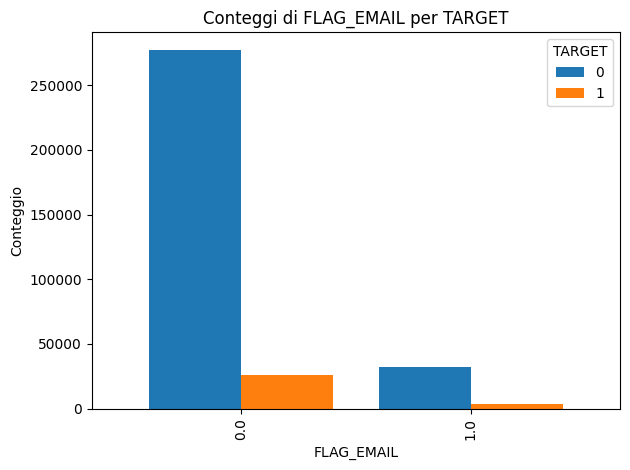

<Figure size 600x400 with 0 Axes>

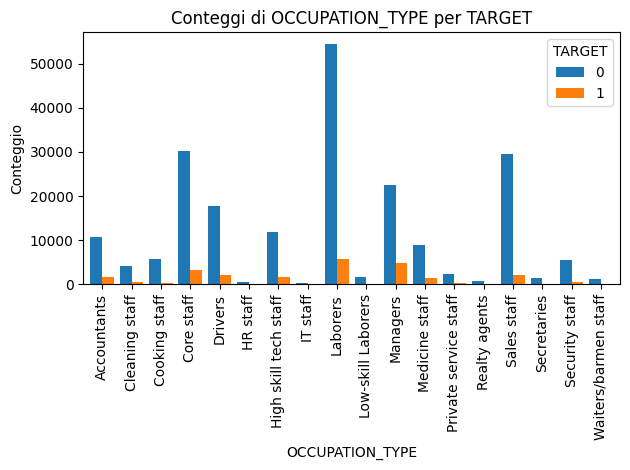

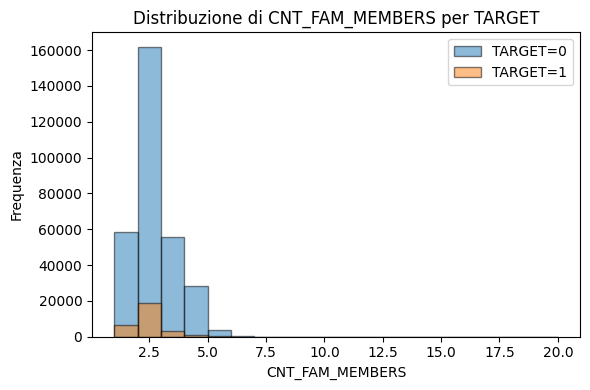

In [ ]:
for col in df.columns:
    if col in ['ID', 'TARGET']:
        continue

    plt.figure(figsize=(6,4))

    # Numerica con più di 10 valori unici → istogrammi sovrapposti
    if pd.api.types.is_numeric_dtype(df[col]) and df[col].nunique() > 10:
        # calcolo del numero di bin come nel tuo original
        unique_vals = df[col].nunique()
        if col == 'CNT_CHILDREN' or col == 'CNT_FAM_MEMBERS':
            n_bins = 19
        elif col == 'DAYS_EMPLOYED' or col == 'AMT_INCOME_TOTAL':
            n_bins = 100

        else:
            n_bins = max(1, int(round(unique_vals ** 0.5)))

        # costruisco bin_edges da min a max
        data_all = df[col].dropna()
        bin_edges = np.linspace(data_all.min(), data_all.max(), n_bins + 1)

        # plotto i due istogrammi con gli stessi bin_edges
        for t_val, color in zip([0, 1], ['C0', 'C1']):
            subset = df.loc[df['TARGET'] == t_val, col].dropna()
            plt.hist(subset, bins=bin_edges, alpha=0.5,
                     label=f'TARGET={t_val}',
                     edgecolor='black',
                     color=color)

        plt.title(f'Distribuzione di {col} per TARGET')
        plt.xlabel(col)
        plt.ylabel('Frequenza')
        plt.legend()

    else:
        # categoriche o discrete → barre affiancate
        ct = pd.crosstab(df[col], df['TARGET'])
        ct.plot(kind='bar', width=0.8)

        plt.title(f'Conteggi di {col} per TARGET')
        plt.xlabel(col)
        plt.ylabel('Conteggio')
        plt.legend(title='TARGET')

    plt.tight_layout()
    plt.show()

Dando una occhiata veloce alle features posso dire che:
- CODE_GENDER: è una varibile catagorica dicotomica -> label encoding (e non sembra essere rilevante per quanto riguarda la previsione del target)
-  FLAG_OWN_CAR: è una varibile catagorica dicotomica -> label encoding (forse ha un lieve impatto, in quanto le distribuzione per target = 0 e target =1 sono lievemente diverse, in particolare chi ha una macchina  sembra essere più affidabile)
- FLAG_OWN_REALTY: è una varibile catagorica dicotomica -> label encoding (e non sembra essere rilevante per quanto riguarda la previsione del target)
- CNT_CHILDREN: Variabile numerica ordinale, posso lasciare così (comunque non sembra avere molta rilevanza)
- AMT_INCOME_TOTAL: variabile numerica continua, lascio così e dopo il preprocessing applicherò la standardizzazione delle variabili (sembra effettivamente che più alto è il salario più affidabile è la persona)
- NAME_INCOME_TYPE: variabile categorica non ordinale -> applico one-hot encoding (in particolare sembra che i pensionati non siano per nulla affidabili)
- NAME_EDUCATION_TYPE: variabile categorica non ordinale -> applico one-hot encoding (non sembra essere molto rilevanti)
- NAME_FAMILY_STATUS: variabile categorica non ordinale -> applico one-hot encoding (non sembra essere molto rilevanti)
- NAME_HOUSING_TYPE: variabile categorica non ordinale -> applico one-hot encoding (dall'istogramma pare che chi quasi tutti i clienti affidabili abbiano una casa/appartamento di proprietà)
- DAYS_BIRTH: variabile numerica continua (qui si vede chiaramente come i clienti affidabili provengono esclusivamente da coloro che hanno almeno 15000 giorni di età, quindi questa è molto significativa come variabile per prevedere il target)
- DAYS_EMPLOYED: variabile numerica continua (qui c'è un aspetto non chiaro nei dati,c'è un cluster di persone che non sta lavorando che ha un numero di giorni estramemente alto (irrealistico per la vita umana), ci sarà qualche errore nella decodificazione della variabile; tuttavia noto che non ci interessa molto il valore assoluto, ma più che altro il fatto se il cliente stia lavorando oppure no, quindi lascio pure così per il momento)
- FLAG_MOBIL: variabile categorica che presenta solo un valore possibile nel dataset -> completamente inutile la rimuovo
- FLAG_WORK_PHONE: è una varibile catagorica dicotomica già decodificata(non sembra avere particolari potenzialità predittive)
- FLAG_PHONE: idem come FLAG_WORK_PHONE
- FLAG_EMAIL: idem come FLAG_WORK_PHONE
- OCCUPATION TYPE: variabile categorica non ordinale -> applico one-hot encoding (sembra essere rilevante, per esempio i managers hanno una buona probabilità di essere affidabili)
- CNT_FAM_MEMBERS: idem come CNT_CHILDREN






### <font color="yellow">***PreProcessing del Dataset***</font>

In [ ]:
# Verifica la presenza di valori mancanti nel DataFrame
missing_values = df.isnull().sum()
print("Valori mancanti per ciascuna colonna:")
print(missing_values)

Valori mancanti per ciascuna colonna:
ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          1
NAME_HOUSING_TYPE           1
DAYS_BIRTH                  1
DAYS_EMPLOYED               1
FLAG_MOBIL                  1
FLAG_WORK_PHONE             1
FLAG_PHONE                  1
FLAG_EMAIL                  1
OCCUPATION_TYPE        103342
CNT_FAM_MEMBERS             1
TARGET                      0
dtype: int64


In [ ]:
df_missing_occ = df[df['NAME_FAMILY_STATUS'].isnull()]
print(df_missing_occ)

             ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL NAME_INCOME_TYPE NAME_EDUCATION_TYPE NAME_FAMILY_STATUS NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  TARGET
338426  6392180           F            N               N             0          68765.48          Working      Secondary / se                NaN               NaN         NaN            NaN         NaN              NaN         NaN         NaN             NaN              NaN       0


E' presente nel dataset la riga 338426 che presenta molti campi NaN, per sicurezza la rimuovo

In [ ]:
df_clean = df.drop(338426)

In [ ]:
# Verifica la presenza di valori mancanti nel DataFrame
missing_values = df_clean.isnull().sum()
print("Valori mancanti per ciascuna colonna:")
print(missing_values)

Valori mancanti per ciascuna colonna:
ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        103341
CNT_FAM_MEMBERS             0
TARGET                      0
dtype: int64


Ok ora sono rimasti solo molte righe con OCCUPATION_TYPE = NaN, in questo caso imposterò manualmente una categoria not defined per queste righe

In [ ]:
# Sostituisci i NaN in OCCUPATION_TYPE con "Not Defined"
df_clean['OCCUPATION_TYPE'] = df_clean['OCCUPATION_TYPE'].fillna('Not Defined')

In [ ]:
# Verifica la presenza di valori mancanti nel DataFrame
missing_values = df_clean.isnull().sum()
print("Valori mancanti per ciascuna colonna:")
print(missing_values)

Valori mancanti per ciascuna colonna:
ID                     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
FLAG_MOBIL             0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
OCCUPATION_TYPE        0
CNT_FAM_MEMBERS        0
TARGET                 0
dtype: int64


DATAFRAME SISTEMATO

Adesso procedo con la trasformazioni delle features, in modo poi da dare il dataset in input al modello di Machine Learning

In [ ]:
# Rimuoviamo la colonna "id" e FLAG_MOBIL poichè non è utile come feature
df_no_id = df_clean.drop("ID", axis=1).drop("FLAG_MOBIL", axis=1)

# LABEL ENCODING PER: CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY
gender_conversion_dict = {"M": 0, "F": 1}
df_no_id["CODE_GENDER"] = df_no_id["CODE_GENDER"].map(gender_conversion_dict)

car_conversion_dict = {"N": 0, "Y": 1}
df_no_id["FLAG_OWN_CAR"] = df_no_id["FLAG_OWN_CAR"].map(car_conversion_dict)

realty_conversion_dict = {"N": 0, "Y": 1}
df_no_id["FLAG_OWN_REALTY"] = df_no_id["FLAG_OWN_REALTY"].map(realty_conversion_dict)

# ONE-HOT Encoding per la variabili categoriche non ordinali
categorical_feats = ['NAME_INCOME_TYPE','NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE','OCCUPATION_TYPE']
prefixes = ['INC','EDU','STATUS','HS_TYPE','OCC']

df_ohe = df_no_id

for feat, pref in zip(categorical_feats, prefixes):
  # One‐hot encoding
  df_ohe = pd.get_dummies(df_ohe,
                          columns=[feat],
                          prefix=pref,
                          drop_first=False)

  # Controllo le nuove colonne
  print(df_ohe.filter(regex=f'^{pref}').columns.tolist())



['INC_Commercial associate', 'INC_Pensioner', 'INC_State servant', 'INC_Student', 'INC_Working']
['EDU_Academic degree', 'EDU_Higher education', 'EDU_Incomplete higher', 'EDU_Lower secondary', 'EDU_Secondary / secondary special']
['STATUS_Civil marriage', 'STATUS_Married', 'STATUS_Separated', 'STATUS_Single / not married', 'STATUS_Widow']
['HS_TYPE_Co-op apartment', 'HS_TYPE_House / apartment', 'HS_TYPE_Municipal apartment', 'HS_TYPE_Office apartment', 'HS_TYPE_Rented apartment', 'HS_TYPE_With parents']
['OCC_Accountants', 'OCC_Cleaning staff', 'OCC_Cooking staff', 'OCC_Core staff', 'OCC_Drivers', 'OCC_HR staff', 'OCC_High skill tech staff', 'OCC_IT staff', 'OCC_Laborers', 'OCC_Low-skill Laborers', 'OCC_Managers', 'OCC_Medicine staff', 'OCC_Not Defined', 'OCC_Private service staff', 'OCC_Realty agents', 'OCC_Sales staff', 'OCC_Secretaries', 'OCC_Security staff', 'OCC_Waiters/barmen staff']


In [ ]:
print(df_ohe)

        CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  DAYS_BIRTH  DAYS_EMPLOYED  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  ...  OCC_Low-skill Laborers  OCC_Managers  OCC_Medicine staff  OCC_Not Defined  OCC_Private service staff  OCC_Realty agents  OCC_Sales staff  OCC_Secretaries  OCC_Security staff  OCC_Waiters/barmen staff
0                 0             1                1             0         424380.57    -11778.0        -4438.0              1.0         0.0         0.0  ...                   False         False               False             True                      False              False            False            False               False                     False
1                 0             1                1             0         421593.52    -11777.0        -4459.0              1.0         0.0         0.0  ...                   False         False               False             True                      False              False          

### <font color="yellow">***Costruzione del modello***</font>
- Poichè abbiamo la classe target nel nostro dataset che è sbilanciata dobbiamo procedere con qualche tecnica per compensare a questo fatto: in particolare dopo le conoscenze acquisite nel progetto precedente e visto che abbiamo tanti dati in questo dataset proverò con l'UnderSampling
- Ora è necessario stabilire quale modello utilizzare per la previsione della classe target. La richiesta è che il modello sia facilmente interpretabile, quindi scarterei i modelli non parametrici (e le reti neurali), poi in particolare si tratta di un problema di classificazione e quindi posso procedere usando Naive Bayes (volendo potrei anche usare la regressione logistica, ma era già stata utilizzata nel progetto precedente)

Mi aspetto tuttavia qualche problemino con NAIVE BAYES, nonstante sia buono per problemi con grande dimensionalità non tutte le feature all'interno del dataset mi sembrano indipendenti

- A posteriori proverò comunque con qualche modello non parametrico più complesso per capire se posso ottenere risultati migliori

In [ ]:
# Funzione di utilità per stampare report
def eval_model(name, model, X_train, y_train, X_test, y_test):
    y_tr_pred = model.predict(X_train)
    y_tr_proba = model.predict_proba(X_train)[:,1]
    y_te_pred = model.predict(X_test)
    y_te_proba = model.predict_proba(X_test)[:,1]

    print(f"\n\n=== {name} - TRAIN SET ===")
    print(classification_report(y_train, y_tr_pred))
    print("Confusion Matrix (train):")
    print(confusion_matrix(y_train, y_tr_pred))
    print("ROC AUC (train):", roc_auc_score(y_train, y_tr_proba))

    print(f"\n=== {name} - TEST SET ===")
    print(classification_report(y_test, y_te_pred))
    print("Confusion Matrix (test):")
    print(confusion_matrix(y_test, y_te_pred))
    print("ROC AUC (test):", roc_auc_score(y_test, y_te_proba))

In [ ]:
RANDOM_SEED = 12
# Splitting preliminare in majority/minority
df_majority = df_ohe[df_ohe['TARGET'] == 0]
df_minority = df_ohe[df_ohe['TARGET'] == 1]

# Undersampling: riduco la classe 0 alla dimensione della classe 1
df_majority_down = resample(df_majority,
                           replace=False,
                           n_samples=len(df_minority),
                           random_state=RANDOM_SEED)

df_balanced = pd.concat([df_majority_down, df_minority])

# Separo feature e target
X = df_balanced.drop(columns=['TARGET'])
y = df_balanced['TARGET']

# Split in train/test e addestramento di Naive Bayes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

# Standardizzazione
ss = StandardScaler()
X_train_std = ss.fit_transform(X_train)
X_test_std = ss.transform(X_test)

In [ ]:
nb = GaussianNB()
nb.fit(X_train_std, y_train)

#valutazione modello
eval_model("Naive Bayes", nb, X_train_std, y_train, X_test_std, y_test)




=== Naive Bayes - TRAIN SET ===
              precision    recall  f1-score   support

           0       0.91      0.29      0.44     23778
           1       0.58      0.97      0.72     23777

    accuracy                           0.63     47555
   macro avg       0.74      0.63      0.58     47555
weighted avg       0.74      0.63      0.58     47555

Confusion Matrix (train):
[[ 6909 16869]
 [  725 23052]]
ROC AUC (train): 0.8140500338552041

=== Naive Bayes - TEST SET ===
              precision    recall  f1-score   support

           0       0.90      0.29      0.43      5944
           1       0.58      0.97      0.72      5945

    accuracy                           0.63     11889
   macro avg       0.74      0.63      0.58     11889
weighted avg       0.74      0.63      0.58     11889

Confusion Matrix (test):
[[1696 4248]
 [ 180 5765]]
ROC AUC (test): 0.8077627947753465


Le metriche ottenute non sono così soddisfacenti, in particolare abbiamo la recall per la classe 0 che è estremamente bassa, sembra che troppi clienti siano predetti appartenenti alla classe positiva

Provo con Random Forest e Rete Neurale

In [ ]:
# Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=5,
    random_state=RANDOM_SEED,
    n_jobs=-1
)
rf.fit(X_train_std, y_train)
eval_model("Random Forest", rf, X_train_std, y_train, X_test_std, y_test)



=== Random Forest - TRAIN SET ===
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     23778
           1       0.97      1.00      0.98     23777

    accuracy                           0.98     47555
   macro avg       0.98      0.98      0.98     47555
weighted avg       0.98      0.98      0.98     47555

Confusion Matrix (train):
[[22928   850]
 [   20 23757]]
ROC AUC (train): 0.9998519163147083

=== Random Forest - TEST SET ===
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      5944
           1       0.95      0.99      0.97      5945

    accuracy                           0.97     11889
   macro avg       0.97      0.97      0.97     11889
weighted avg       0.97      0.97      0.97     11889

Confusion Matrix (test):
[[5656  288]
 [  50 5895]]
ROC AUC (test): 0.9814208757486471


Con Random Forest ho ottenuto delle metriche veramente buone, un AUC clamoroso. Forse c'è un filo di overfitting però comunque anche i risultati sui dati di test sono estremamente buoni.

Ora provo con una rete neurale, non passo i dati standardizzati tanto non c'è bisogno (inoltre la standardizzazione mi va a rimuovere i nome delle feature e la funzione model.predict mi da un warning)

In [ ]:
# Rete Neurale (MLP)
mlp = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    max_iter=200,
    random_state=42
)
mlp.fit(X_train, y_train)
eval_model("MLP Neural Net", mlp, X_train, y_train, X_test, y_test)



=== MLP Neural Net - TRAIN SET ===
              precision    recall  f1-score   support

           0       0.99      0.65      0.79     23778
           1       0.74      0.99      0.85     23777

    accuracy                           0.82     47555
   macro avg       0.86      0.82      0.82     47555
weighted avg       0.86      0.82      0.82     47555

Confusion Matrix (train):
[[15552  8226]
 [  207 23570]]
ROC AUC (train): 0.945607743831872

=== MLP Neural Net - TEST SET ===
              precision    recall  f1-score   support

           0       0.99      0.65      0.78      5944
           1       0.74      0.99      0.85      5945

    accuracy                           0.82     11889
   macro avg       0.86      0.82      0.81     11889
weighted avg       0.86      0.82      0.81     11889

Confusion Matrix (test):
[[3856 2088]
 [  52 5893]]
ROC AUC (test): 0.9477619967467601


Le metriche per quanto riguarda la rete neurali non sono male, ma peggio di Random Forest (ovviamente avrei potuto andare a fare un tuning migliore degli iperparametri per poi trovare dei risultati migliori, però ho già il modello random forest che performa benissimo e ci mette molto meno tempo per l'addestramento e quindi mi affiderò a quello, inoltre la rete neurale è praticamente impossibile da interpretare, mentre invece random forest sì)

### <font color="yellow">***Interpretabilità del risultato***</font>

Procedo utlizzando questa libreria shap, pensata per rendere “interpretabili” i modelli di machine learning, usando i valori shapley (li avevo studiati in università in game theory, ora ho qualche vago ricordo)
In particolare userò la classe Explainer per poi usare i metodi:
- plots.bars (per vedere vedere quali sono le features che hanno i contributi più rilevanti)
- plots.beeswarm (per valutare se valori alti o bassi di una specifica feature hanno effetto negativo o positivo sul risultato)
- waterfall_plot (per andare a visulizzare i contributi per una singola osservazione)

In [ ]:
# Ricostruisco DataFrame con i nomi delle colonne
feature_names = X.columns
X_train_df = pd.DataFrame(X_train_std, columns=feature_names)
X_test_df  = pd.DataFrame(X_test_std,  columns=feature_names)

# Per ragioni di performance, campiono un sottoinsieme del train
sample_idx = np.random.choice(X_train_df.shape[0], size=100, replace=False)
X_shap_sample = X_train_df.iloc[sample_idx]

In [ ]:
expl = shap.Explainer(rf)
shap_values = expl(X_shap_sample)
shap_vals_water_class1 = shap_values[:, :, 1]

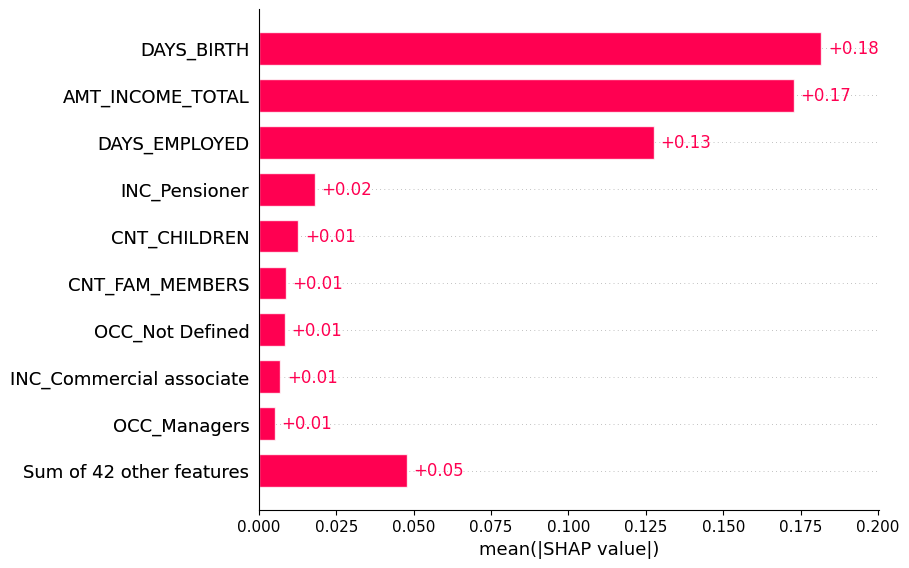

In [ ]:
shap.plots.bar(shap_vals_water_class1)

Come avevo intuito anche dalla analisi esplorativa dei dati è chiaro come DAYS_BIRTH, AMT_INCOME_TOTAL & DAYS_EMPLOYED siano le feature che hanno maggiori effetti sulla previsione della colonna target

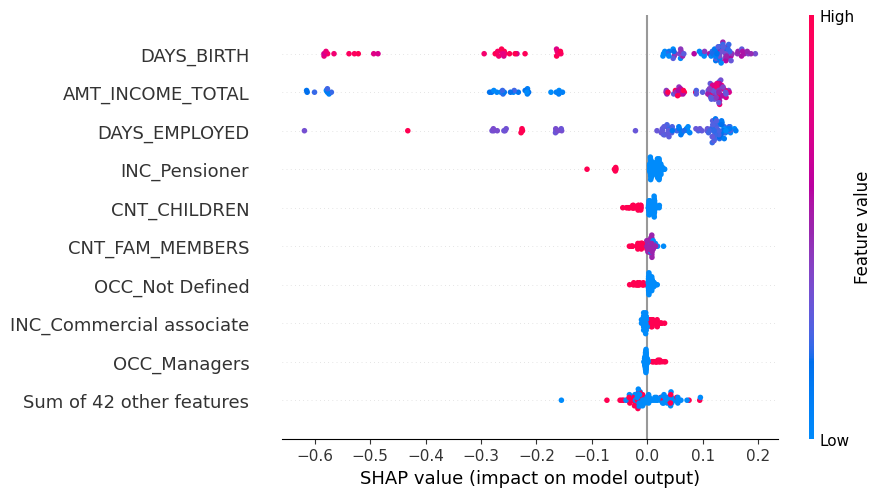

In [ ]:
shap.plots.beeswarm(shap_vals_water_class1)

Da questo grafico notiamo come valori alti di DAYS_BIRTH (ricordo che è una variabile negativa, quindi valori alti corrispondono a persone giovani) abbiano un effetto molto negativo sulla previsione della variabile target, cioè spingono molto verso la classe 0 di inaffidabilità

AMT_INCOME_TOTAL invece ci fa vedere come valori bassi di reddito portano la previsione di affidabilità verso lo 0

I pensionati sembrano essere tutti inaffidibili dal punto di vista creditizio, come si era visto come dall'analisi esplorativa

Una famiglia numerosa è quasi sempre associata a una minore affidabilità creditizia

E' interessante notare come l'occupazione Manager sia altamente rilevante per quanto riguarda l'affidabilità (fatto che avevo già notato dall'analisi esplorativa)

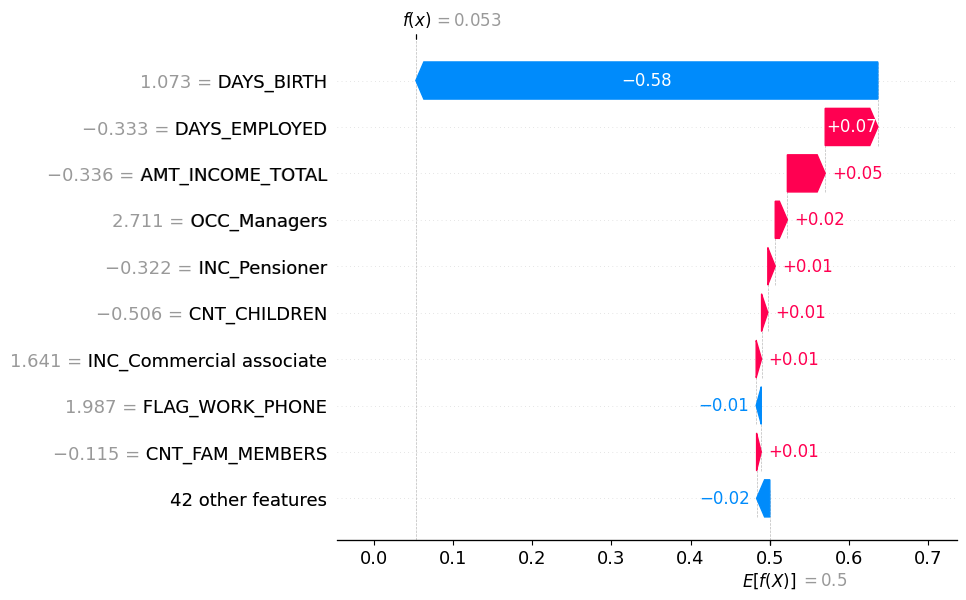

In [ ]:
i = 15 # seleziono qui un indice per vedere una osservazione
shap.waterfall_plot(
    shap_vals_water_class1[i]
)

In questo grafico possiamo vedere come sia stata influenzata la decisione sull'affidabilità rispetto alle varie features.

In questo caso particolare abbiamo molte features che porterebbero a pensare che la persona in questione sia affidabile (molti contributi rossi positivi), però basta una sola feature come days_birth molto grande per far cambiare completamente la previsione.
Evidentemente la persona in questione era molto giovane e perciò è stata classificata come non affidabile (ricordo che le variabili erano state standardizzate)